<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/Funzioni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importo librerie

In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 59.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show
import cv2

GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Funzione per dividere il dataset in training, validation e test set

In [ ]:
def split_dataset(image_dir, drive_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
  images = sorted(os.listdir(image_dir))

  combined = [(img, img) for img in images]
  random.seed(seed)
  random.shuffle(combined)

  train_split = int(len(combined) * train_ratio)
  val_split = int(len(combined) * (train_ratio + val_ratio))
  train_data = combined[:train_split]
  val_data = combined[train_split:val_split]
  test_data = combined[val_split:]

  with open(os.path.join(drive_dir, 'train.txt'), 'w') as f:
    for img, lbl in train_data:
      s = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/' + img
      f.write(f"{s} {s}\n")

  with open(os.path.join(drive_dir, 'val.txt'), 'w') as f:
    for img, lbl in val_data:
      s = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/' + img
      f.write(f"{s} {s}\n")


  with open(os.path.join(drive_dir, 'test.txt'), 'w') as f:
    for img, lbl in test_data:
      s = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/' + img
      f.write(f"{s} {s}\n")


Definisco alcune directory

In [3]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

Faccio split del dataset

In [ ]:
split_dataset(image_dir, drive_dir)

Path delle immagini

In [ ]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]

Funzione per calcolare media e deviazione standard

In [ ]:
def compute_mean_std(image_paths):
    mean = np.zeros(4)
    std = np.zeros(4)
    nb_samples = 0

    # Abilita l'uso della GPU per OpenCV
    cv2.setUseOptimized(True)
    cv2.setNumThreads(8)
    cv2.ocl.setUseOpenCL(True)

    for image_path in image_paths:
        try:
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

            for i in range(4):
                mean[i] += np.mean(image[:,:,i])
                std[i] += np.std(image[:,:,i])

            nb_samples += 1

            if nb_samples % 10 == 0:
                print(f"Processed {nb_samples} images")

        except Exception as e:
            print(f"Error loading image: {image_path}")
            print(e)
            continue

    mean /= nb_samples
    std /= nb_samples

    return mean, std

Calcolo media e std su training set

In [ ]:
mean, std = compute_mean_std(train_image_paths)
print("Mean: ", mean)
print("Std: ", std)

Processed 10 images
Processed 20 images
Processed 30 images
Processed 40 images
Processed 50 images
Processed 60 images
Processed 70 images
Processed 80 images
Processed 90 images
Processed 100 images
Processed 110 images
Processed 120 images
Processed 130 images
Processed 140 images
Processed 150 images
Processed 160 images
Processed 170 images
Processed 180 images
Processed 190 images
Processed 200 images
Processed 210 images
Processed 220 images
Processed 230 images
Processed 240 images
Processed 250 images
Processed 260 images
Processed 270 images
Processed 280 images
Processed 290 images
Processed 300 images
Processed 310 images
Processed 320 images
Processed 330 images
Processed 340 images
Processed 350 images
Processed 360 images
Processed 370 images
Processed 380 images
Processed 390 images
Processed 400 images
Processed 410 images
Processed 420 images
Processed 430 images
Processed 440 images
Processed 450 images
Processed 460 images
Processed 470 images
Processed 480 images
P

In [4]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
import os

def geojson_to_tif(geojson_path, output_directory, resolution=1):
    # Ottenere il nome del file senza estensione
    base_filename = os.path.splitext(os.path.basename(geojson_path))[0]
    tif_filename = base_filename + '.tif'
    tif_path = os.path.join(output_directory, tif_filename)

    # Leggere il file .geojson
    gdf = gpd.read_file(geojson_path)

    # Determinare i bounds dell'area di interesse
    minx, miny, maxx, maxy = gdf.total_bounds

    # Calcolare le dimensioni del raster
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)

    # Creare una trasformazione affine
    transform = from_bounds(minx, miny, maxx, maxy, width, height)

    # Creare un array vuoto per il raster
    raster = np.zeros((height, width), dtype=np.uint8)

    # Rasterizzare il geojson
    shapes = ((geom, 1) for geom in gdf.geometry)
    rasterized = rasterize(shapes, out_shape=raster.shape, transform=transform, fill=0, default_value=1, dtype=np.uint8)

    # Scrivere il raster su file .tif
    with rasterio.open(
        tif_path,
        'w',
        driver='GTiff',
        height=rasterized.shape[0],
        width=rasterized.shape[1],
        count=1,
        dtype=rasterized.dtype,
        crs=gdf.crs,
        transform=transform
    ) as dst:
        dst.write(rasterized, 1)

    print(f"File {tif_path} creato con successo.")

# Esempio di utilizzo:
geojson_path = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/geojson_buildings/SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.geojson'
tif_path = '/content/drive/MyDrive/Labels'
geojson_to_tif(geojson_path, tif_path, resolution=1)


File /content/drive/MyDrive/Labels/SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif creato con successo.


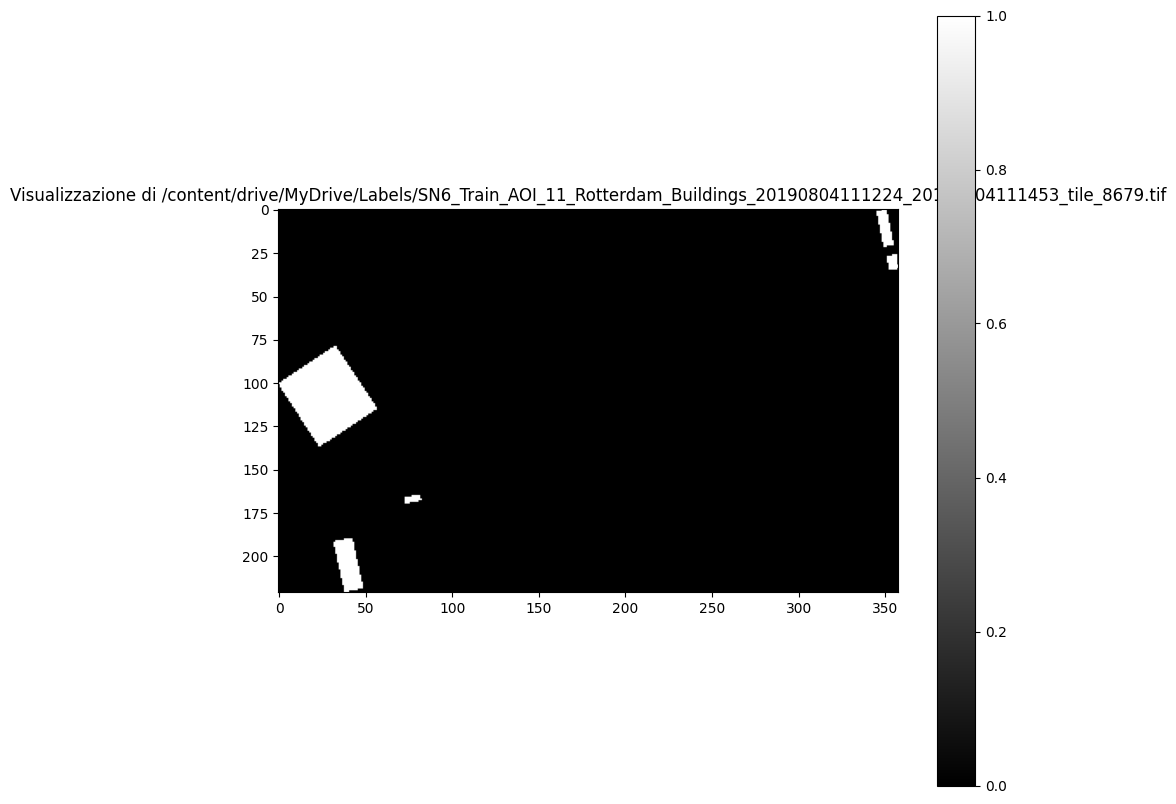

In [5]:
import rasterio
import matplotlib.pyplot as plt

def visualize_tif(tif_path):
    # Aprire il file .tif
    with rasterio.open(tif_path) as src:
        # Leggere il primo (e unico) band
        data = src.read(1)

        # Visualizzare l'immagine
        plt.figure(figsize=(10, 10))
        plt.imshow(data, cmap='gray')
        plt.colorbar()
        plt.title(f"Visualizzazione di {tif_path}")
        plt.show()

# Esempio di utilizzo:
tif_path = '/content/drive/MyDrive/Labels/SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif'
visualize_tif(tif_path)
